In [1]:
import os, json, io
import numpy as np
import pandas as pd
# from models.load import TrainedModels

from utils.engine import get_iou_types, evaluate
from models.load import get_trained_model
from utils.print import print_title
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.paths import MIMIC_EYE_PATH
from tqdm import tqdm
from utils.train import  get_coco_eval_params
from utils.coco_eval import get_eval_params_dict
from data.strs import SourceStrs, TaskStrs
from IPython.display import clear_output
from coco_froc_analysis.froc.froc_curve import get_froc_curve, get_interpolate_froc
from pathlib import Path
from coco_froc_analysis.froc.froc_curve import TempRecord
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from enum import Enum

class ImageSizeTest(Enum):
    size128 = "lesion-detection_val_ap_0_0856_test_ap_0_0693_epoch67_05-23-2023 13-53-13_baseline_mobilenet"
    size512 = "lesion-detection_val_ap_0_1283_test_ap_0_1174_epoch42_05-23-2023 16-38-06_baseline_mobilenet"

class APNatureModels(Enum):
    baseline_mobilenet = "lesion-detection_val_ap_0_1281_test_ap_0_1180_epoch49_05-17-2023 18-16-58_baseline_mobilenet"
    clinical_mobilenet_sum = "lesion-detection_val_ap_0_1542_test_ap_0_1294_epoch60_05-17-2023 21-23-17_clinical_mobilenet_sum"
    clinical_mobilenet_hadamard = "lesion-detection_val_ap_0_1296_test_ap_0_1427_epoch35_05-17-2023 23-33-46_clinical_mobilenet_hadamard"
    clinical_mobilenet_concat_conv = "lesion-detection_val_ap_0_1272_test_ap_0_1639_epoch35_05-18-2023 01-43-56_clinical_mobilenet_concat_conv"
    clinical_mobilenet_concat_linear = "lesion-detection_val_ap_0_1294_test_ap_0_1415_epoch55_05-18-2023 04-57-29_clinical_mobilenet_concat_linear"
    clinical_mobilenet_concat_convb = "lesion-detection_val_ap_0_1252_test_ap_0_1343_epoch61_05-18-2023 09-09-04_clinical_mobilenet_concat_convb"
    clinical_mobilenet_concat_conv_nb = "lesion-detection_val_ap_0_1220_test_ap_0_1149_epoch42_05-18-2023 22-56-01_clinical_mobilenet_concat_convb_nb"
    clinical_mobilenet_concat_conv_inter = "lesion-detection_val_ap_0_1233_test_ap_0_1402_epoch42_05-19-2023 01-13-45_clinical_mobilenet_concat_conv_inter"
    clinical_mobilenet_concat_conv_repeat = "lesion-detection_val_ap_0_1348_test_ap_0_1446_epoch60_05-19-2023 04-13-39_clinical_mobilenet_concat_conv_repeat"
    clinical_mobilenet_concat_deform = "lesion-detection_val_ap_0_1405_test_ap_0_1231_epoch47_05-19-2023 07-34-33_clinical_mobilenet_concat_deform"

class FROCNatureModels(Enum):

    baseline_mobilenet = "lesion-detection_val_froc_0_8257_test_froc_0_7691_epoch35_05-17-2023 17-46-23_baseline_mobilenet"
    clinical_mobilenet_sum = "lesion-detection_val_froc_0_8014_test_froc_0_7331_epoch31_05-17-2023 20-03-34_clinical_mobilenet_sum"
    clinical_mobilenet_hadamard = "lesion-detection_val_froc_0_8369_test_froc_0_7545_epoch25_05-17-2023 23-06-47_clinical_mobilenet_hadamard"
    clinical_mobilenet_concat_conv = "lesion-detection_val_froc_0_8185_test_froc_0_8069_epoch29_05-18-2023 01-26-37_clinical_mobilenet_concat_conv"
    clinical_mobilenet_concat_linear = "lesion-detection_val_froc_0_8233_test_froc_0_7907_epoch32_05-18-2023 03-48-49_clinical_mobilenet_concat_linear"
    clinical_mobilenet_concat_convb = "lesion-detection_val_froc_0_8047_test_froc_0_7226_epoch32_05-18-2023 07-51-15_clinical_mobilenet_concat_convb"
    clinical_mobilenet_concat_convb_nb = "lesion-detection_val_froc_0_8020_test_froc_0_7185_epoch30_05-18-2023 22-28-31_clinical_mobilenet_concat_convb_nb"
    clinical_mobilenet_concat_conv_inter = "lesion-detection_val_froc_0_8402_test_froc_0_7701_epoch26_05-19-2023 00-31-44_clinical_mobilenet_concat_conv_inter"
    clinical_mobilenet_concat_conv_repeat = "lesion-detection_val_froc_0_8312_test_froc_0_7636_epoch27_05-19-2023 02-54-07_clinical_mobilenet_concat_conv_repeat"
    clinical_mobilenet_concat_deform = "lesion-detection_val_froc_0_7905_test_froc_0_7824_epoch25_05-19-2023 06-14-09_clinical_mobilenet_concat_deform"

    
class NatureModels(Enum):
    clinical_convnext_base_sum_ap_3D = "lesion-detection_val_ap_0_1375_test_ap_0_1823_epoch22_05-16-2023 18-23-36_clinical_convnext_base_sum"
    clinical_convnext_base_sum_froc_3D = "lesion-detection_val_froc_0_8378_test_froc_0_7804_epoch26_05-16-2023 18-36-07_clinical_convnext_base_sum"
    clinical_convnext_base_sum_ar_3D = "lesion-detection_val_ar_0_6835_test_ar_0_6754_epoch39_05-16-2023 19-17-06_clinical_convnext_base_sum"
    baseline_convnext_base_ap = 'lesion-detection_val_ap_0_1560_test_ap_0_1567_epoch52_05-16-2023 22-20-39_baseline_convnext_base'
    baseline_convnext_base_froc = 'lesion-detection_val_froc_0_8560_test_froc_0_8079_epoch59_05-16-2023 22-47-45_baseline_convnext_base'
    baseline_convnext_base_ar = 'lesion-detection_val_ar_0_7054_test_ar_0_7032_epoch60_05-16-2023 22-51-45_baseline_convnext_base'
    clinical_convnext_base_sum_ap_1D_3D = "lesion-detection_val_ap_0_1373_test_ap_0_1393_epoch34_05-17-2023 02-45-30_clinical_convnext_base_sum"
    clinical_convnext_base_sum_froc_1D_3D = "lesion-detection_val_froc_0_8189_test_froc_0_7287_epoch157_05-17-2023 12-15-01_clinical_convnext_base_sum"
    clinical_convnext_base_sum_ar_1D_3D = "lesion-detection_val_ar_0_7309_test_ar_0_6901_epoch60_05-17-2023 07-00-34_clinical_convnext_base_sum"

class FROCEarlyStopModels(Enum):
    baseline_mobilenet = "val_lesion-detection_froc_0_8214_test_lesion-detection_froc_0_7215_epoch29_05-08-2023 03-29-15_lesion_dsetection_baseline_mobilenet"
    with_clinical_mobilenet_1D_3D = "val_lesion-detection_froc_0_7802_test_lesion-detection_froc_0_7193_epoch27_05-08-2023 04-57-59_lesion_dsetection_with_clinical_mobilenet"
    with_clinical_mobilenet_3D = "val_lesion-detection_froc_0_8345_test_lesion-detection_froc_0_7381_epoch31_05-08-2023 08-28-01_lesion_dsetection_with_clinical_mobilenet"
    baseline_resnet18 = "val_lesion-detection_froc_0_8262_test_lesion-detection_froc_0_7828_epoch21_05-08-2023 10-52-48_lesion_dsetection_baseline_resnet18"
    with_clinical_resnet18_1D_3D = "val_lesion-detection_froc_0_8063_test_lesion-detection_froc_0_7156_epoch21_05-08-2023 17-24-35_lesion_dsetection_with_clinical_resnet18"
    with_clinical_resnet18_3D = "val_lesion-detection_froc_0_8391_test_lesion-detection_froc_0_7007_epoch51_05-09-2023 00-03-18_lesion_dsetection_with_clinical_resnet18"
    baseline_convnext_base = "val_lesion-detection_froc_0_8422_test_lesion-detection_froc_0_7991_epoch39_05-09-2023 03-20-36_lesion_dsetection_baseline_convnext_base"
    with_clinical_convnext_base_1D_3D = "val_lesion-detection_froc_0_8248_test_lesion-detection_froc_0_7867_epoch45_05-09-2023 07-31-28_lesion_dsetection_with_clinical_convnext_base_1D_3D"
    with_clinical_convnext_base_3D = "val_lesion-detection_froc_0_8104_test_lesion-detection_froc_0_7584_epoch62_05-09-2023 12-56-34_lesion_dsetection_with_clinical_convnext_base_3D"
    with_clinical_convnext_base_3D_2nd = "val_lesion-detection_froc_0_8148_test_lesion-detection_froc_0_7649_epoch39_05-09-2023 17-27-41_lesion_dsetection_with_clinical_convnext_base_3D"
    with_clinical_convnext_base_1D_3D_2nd = "val_lesion-detection_froc_0_8409_test_lesion-detection_froc_0_8003_epoch29_05-09-2023 19-09-54_lesion_dsetection_with_clinical_convnext_base_1D_3D"
    baseline_convnext_base_2nd = "val_lesion-detection_froc_0_8597_test_lesion-detection_froc_0_8035_epoch41_05-09-2023 21-40-22_lesion_dsetection_baseline_convnext_base"
    baseline_efficientnet_b0 = "val_lesion-detection_froc_0_8301_test_lesion-detection_froc_0_7479_epoch23_05-09-2023 23-23-11_lesion_dsetection_baseline_efficientnet_b0"
    with_clinical_efficientnet_b0_1D_3D = "val_lesion-detection_froc_0_7876_test_lesion-detection_froc_0_7051_epoch35_05-10-2023 07-17-37_lesion_dsetection_with_clinical_efficientnet_b0_1D_3D"
    with_clinical_efficientnet_b0_3D = "val_lesion-detection_froc_0_8321_test_lesion-detection_froc_0_7246_epoch25_05-10-2023 09-19-11_lesion_dsetection_with_clinical_efficientnet_b0_3D"
    baseline_densenet = "val_lesion-detection_froc_0_8442_test_lesion-detection_froc_0_6942_epoch33_05-10-2023 17-06-03_lesion_dsetection_baseline_densenet"
    with_clinical_densenet_1D_3D = "val_lesion-detection_froc_0_8303_test_lesion-detection_froc_0_7089_epoch33_05-10-2023 19-11-45_lesion_dsetection_with_clinical_densenet_1D_3D"
    with_clinical_densenet_3D  = "val_lesion-detection_froc_0_8310_test_lesion-detection_froc_0_7144_epoch12_05-10-2023 20-13-22_lesion_dsetection_with_clinical_densenet_3D"
    baseline_resnet50 = "val_lesion-detection_froc_0_8350_test_lesion-detection_froc_0_7959_epoch15_05-10-2023 21-30-40_lesion_dsetection_baseline_resnet50"
    with_clinical_resnet50_1D_3D = "val_lesion-detection_froc_0_8119_test_lesion-detection_froc_0_7458_epoch15_05-10-2023 22-32-10_lesion_dsetection_with_clinical_resnet50_1D_3D"
    with_clinical_resnet50_3D = "val_lesion-detection_froc_0_8260_test_lesion-detection_froc_0_7630_epoch15_05-10-2023 23-35-14_lesion_dsetection_with_clinical_resnet50_3D"
    baseline_efficientnet_b5 = "val_lesion-detection_froc_0_8016_test_lesion-detection_froc_0_7337_epoch35_05-11-2023 01-44-17_lesion_dsetection_baseline_efficientnet_b5"
    with_clinical_efficientnet_b5_1D_3D = "val_lesion-detection_froc_0_8027_test_lesion-detection_froc_0_6531_epoch26_05-11-2023 03-42-43_lesion_dsetection_with_clinical_efficientnet_b5_1D_3D"
    with_clinical_efficientnet_b5_3D = "val_lesion-detection_froc_0_8209_test_lesion-detection_froc_0_6131_epoch34_05-11-2023 06-05-03_lesion_dsetection_with_clinical_efficientnet_b5_3D"
    with_clinical_convnext_base_3D_hadamard = "val_lesion-detection_froc_0_8236_test_lesion-detection_froc_0_7954_epoch42_05-11-2023 14-58-09_lesion_dsetection_with_clinical_convnext_base_3D_hadamard"

    # changed file names.
    with_clinical_convnext_base_3D_cocat_token_mixer = "val_froc_0_7650_test_froc_0_7231_epoch25_05-11-2023 19-32-51_clinical_convnext_3D_cocat_token_mixer"
    with_clinical_convnext_base_3D_hadamard_2nd = "val_froc_0_8186_test_froc_0_7648_epoch61_05-11-2023 22-43-35_clinical_convnext_3D_hadamard"
    with_clinical_expander_convnext_base_3D_cocat = "val_froc_0_8453_test_froc_0_7186_epoch51_05-12-2023 02-57-57_clinical_expander_convnext_3D_cocat"
    with_clinical_convnext_base_3D_cocat = "val_froc_0_7863_test_froc_0_7991_epoch13_05-12-2023 04-03-12_clinical_convnext_3D_cocat"
    with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer = "val_froc_0_7976_test_froc_0_7680_epoch28_05-12-2023 15-26-58_clinical_convnext_3D_cocat_with_mixer"
    with_clinical_convnext_base_3D_cocat_pos_weight_10 = "val_froc_0_8070_test_froc_0_7986_epoch18_05-12-2023 21-53-37_clinical_convnext_3D_cocat_pos_weight_10"
    with_clinical_convnext_base_3D_cocat_pos_weight_100 = "val_froc_0_7888_test_froc_0_7747_epoch13_05-12-2023 23-17-06_clinical_convnext_3D_cocat_pos_weight_100"
    with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd = "val_froc_0_8227_test_froc_0_7324_epoch70_05-13-2023 04-26-25_clinical_convnext_3D_cocat_pos_weight_10"
    with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd  = "val_froc_0_8216_test_froc_0_7314_epoch65_05-13-2023 07-51-16_clinical_convnext_3D_cocat_pos_weight_100"

    ap_lesion_dsetection_with_clinical_convnext_base_3D = "val_lesion-detection_ap_0_1290_test_lesion-detection_ap_0_1564_epoch60_05-14-2023 00-32-39_lesion_dsetection_with_clinical_convnext_base_3D"
    ap_lesion_dsetection_with_clinical_convnext_base_1D_3D = "val_lesion-detection_ap_0_0970_test_lesion-detection_ap_0_1072_epoch56_05-14-2023 03-54-58_lesion_dsetection_with_clinical_convnext_base_1D_3D"
    ap_lesion_dsetection_baseline_convnext_base = "val_lesion-detection_ap_0_1309_test_lesion-detection_ap_0_1245_epoch56_05-14-2023 07-09-35_lesion_dsetection_baseline_convnext_base"
    ap_clinical_efficientnet_b0_3D =  "val_lesion-detection_ap_0_1138_test_lesion-detection_ap_0_1088_epoch68_05-14-2023 17-09-14_clinical_efficientnet_b0_3D"
    ap_clinical_efficientnet_b0_1D_3D =  "val_lesion-detection_ap_0_1202_test_lesion-detection_ap_0_1081_epoch30_05-14-2023 19-10-56_clinical_efficientnet_b0_1D_3D"
    ap_baseline_efficientnet_b0 =  "val_lesion-detection_ap_0_1127_test_lesion-detection_ap_0_1156_epoch36_05-14-2023 21-39-07_baseline_efficientnet_b0"

    ap_clinical_densenet_3D = "val_lesion-detection_ap_0_1240_test_lesion-detection_ap_0_1129_epoch56_05-15-2023 13-04-42_clinical_densenet_3D"
    ap_clinical_densenet_1D_3D = "val_lesion-detection_ap_0_1182_test_lesion-detection_ap_0_1200_epoch26_05-15-2023 16-25-55_clinical_densenet_1D_3D"
    ap_baseline_densenet = "val_lesion-detection_ap_0_1382_test_lesion-detection_ap_0_1230_epoch21_05-15-2023 18-19-01_baseline_densenet"

    # file names too long.
    # with_clinical_convnext_base_3D_cocat_token_mixer = "val_lesion-detection_froc_0_7650_test_lesion-detection_froc_0_7231_epoch25_05-11-2023 19-32-51_lesion_dsetection_with_clinical_convnext_base_3D_cocat_token_mixer"
    # with_clinical_convnext_base_3D_hadamard_2nd = "val_lesion-detection_froc_0_8186_test_lesion-detection_froc_0_7648_epoch61_05-11-2023 22-43-35_lesion_dsetection_with_clinical_convnext_base_3D_hadamard"
    # with_clinical_expander_convnext_base_3D_cocat = "val_lesion-detection_froc_0_8453_test_lesion-detection_froc_0_7186_epoch51_05-12-2023 02-57-57_lesion_dsetection_with_clinical_expander_convnext_base_3D_cocat"
    # with_clinical_convnext_base_3D_cocat = "val_lesion-detection_froc_0_7863_test_lesion-detection_froc_0_7991_epoch13_05-12-2023 04-03-12_lesion_dsetection_with_clinical_convnext_base_3D_cocat"
    # with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer = "val_lesion-detection_froc_0_7976_test_lesion-detection_froc_0_7680_epoch28_05-12-2023 15-26-58_lesion_dsetection_with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer"
    # with_clinical_convnext_base_3D_cocat_pos_weight_10 = "val_lesion-detection_froc_0_8070_test_lesion-detection_froc_0_7986_epoch18_05-12-2023 21-53-37_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10"
    # with_clinical_convnext_base_3D_cocat_pos_weight_100 = "val_lesion-detection_froc_0_7888_test_lesion-detection_froc_0_7747_epoch13_05-12-2023 23-17-06_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100"
    # with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd = "val_lesion-detection_froc_0_8227_test_lesion-detection_froc_0_7324_epoch70_05-13-2023 04-26-25_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10"
    # with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd  = "val_lesion-detection_froc_0_8216_test_lesion-detection_froc_0_7314_epoch65_05-13-2023 07-51-16_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100"


class RetrainedModels(Enum):
    mobilenet_with_fix = "val_lesion-detection_froc_0_7916_test_lesion-detection_froc_0_8150_epoch15_04-01-2023 03-02-43_lesion_dsetection_with_fix_mobilenet"
    mobilenet_baseline = "val_lesion-detection_froc_0_7764_test_lesion-detection_froc_0_8036_epoch8_04-01-2023 07-46-01_lesion_dsetection_baseline_mobilenet"
    resnet18_with_fix = "val_lesion-detection_froc_0_7982_test_lesion-detection_froc_0_8257_epoch5_04-01-2023 11-24-08_lesion_dsetection_with_fix_resnet18"
    resnet18_baseline = "val_lesion-detection_froc_0_7893_test_lesion-detection_froc_0_8075_epoch5_04-01-2023 13-53-42_lesion_dsetection_baseline_resnet18"
    densenet_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8169_epoch12_04-02-2023 03-08-03_lesion_dsetection_with_fix_densenet"
    densenet_baseline = "val_lesion-detection_froc_0_7841_test_lesion-detection_froc_0_7864_epoch7_04-02-2023 06-38-49_lesion_dsetection_baseline_densenet"
    efficientnet_b5_with_fix = "val_lesion-detection_froc_0_7980_test_lesion-detection_froc_0_8006_epoch7_04-02-2023 19-25-56_lesion_dsetection_with_fix_efficientnet_b5"
    efficientnet_b5_baseline = "val_lesion-detection_froc_0_7846_test_lesion-detection_froc_0_8189_epoch5_04-02-2023 22-14-38_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b0_with_fix = "val_lesion-detection_froc_0_8030_test_lesion-detection_froc_0_8089_epoch7_04-02-2023 12-42-11_lesion_dsetection_with_fix_efficientnet_b0"
    efficientnet_b0_baseline = "val_lesion-detection_froc_0_7939_test_lesion-detection_froc_0_8115_epoch5_04-02-2023 15-17-34_lesion_dsetection_baseline_efficientnet_b0"
    vgg16_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8247_epoch9_04-03-2023 01-53-49_lesion_dsetection_with_fix_vgg16"
    vgg16_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_7991_epoch8_04-03-2023 04-59-07_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix ="val_lesion-detection_froc_0_8059_test_lesion-detection_froc_0_8284_epoch7_04-03-2023 10-01-30_lesion_dsetection_with_fix_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_froc_0_7862_test_lesion-detection_froc_0_8172_epoch5_04-03-2023 14-04-49_lesion_dsetection_baseline_regnet_y_8gf"
    convnext_base_with_fix = "val_lesion-detection_froc_0_8141_test_lesion-detection_froc_0_8278_epoch7_04-03-2023 17-07-24_lesion_dsetection_with_fix_convnext_base"
    convnext_base_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_8092_epoch11_04-03-2023 21-17-10_lesion_dsetection_baseline_convnext_base"
    resnet50_with_fix = "val_lesion-detection_froc_0_8201_test_lesion-detection_froc_0_8307_epoch7_04-04-2023 01-13-30_lesion_dsetection_with_fix_resnet50"
    resnet50_baseline = "val_lesion-detection_froc_0_7882_test_lesion-detection_froc_0_8111_epoch6_04-04-2023 04-00-17_lesion_dsetection_baseline_resnet50"
    resnet50_with_fix_silent = "val_lesion-detection_froc_0_7947_test_lesion-detection_froc_0_8172_epoch8_04-04-2023 22-46-16_ld_with_fix_resnet50_silent"
    resnet50_with_fix_full = "val_lesion-detection_froc_0_8135_test_lesion-detection_froc_0_8361_epoch10_04-05-2023 04-40-29_ld_with_fix_resnet50_full"

class TrainedModels(Enum):
    mobilenet_baseline = "val_lesion-detection_ap_0_1655_test_lesion-detection_ap_0_1648_epoch50_03-15-2023 16-43-54_lesion_dsetection_baseline_mobilenet"  # mobilenet baseline
    mobilenet_with_fix = "val_lesion-detection_ap_0_1918_test_lesion-detection_ap_0_1903_epoch16_03-16-2023 11-34-10_lesion_dsetection_with_fixation_mobilenet"
    resnet18_baseline = "val_lesion-detection_ap_0_1973_test_lesion-detection_ap_0_2010_epoch22_03-16-2023 19-44-55_lesion_dsetection_baseline_resnet"
    resnet18_with_fix = "val_lesion-detection_ap_0_1951_test_lesion-detection_ap_0_2195_epoch12_03-17-2023 00-31-54_lesion_dsetection_with_fixation_resnet"
    densenet161_baseline = "val_lesion-detection_ap_0_1990_test_lesion-detection_ap_0_2085_epoch5_03-17-2023 08-53-33_lesion_dsetection_baseline_densenet161"
    densenet161_with_fix = "val_lesion-detection_ap_0_2120_test_lesion-detection_ap_0_2104_epoch12_03-17-2023 18-36-01_lesion_dsetection_with_fixation_densenet161"
    efficientnet_b5_baseline = "val_lesion-detection_ap_0_1898_test_lesion-detection_ap_0_2055_epoch5_03-17-2023 23-30-57_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b5_with_fix = "val_lesion-detection_ap_0_2117_test_lesion-detection_ap_0_2190_epoch8_03-18-2023 12-29-20_lesion_dsetection_with_fixation_efficientnet_b5"
    efficientnet_b0_baseline = "val_lesion-detection_ap_0_1934_test_lesion-detection_ap_0_1858_epoch10_03-18-2023 23-50-47_lesion_dsetection_baseline_efficientnet_b0"
    efficientnet_b0_with_fix = "val_lesion-detection_ap_0_2191_test_lesion-detection_ap_0_2162_epoch10_03-18-2023 19-38-11_lesion_dsetection_with_fixation_efficientnet_b0"
    convnext_base_with_fix = "val_lesion-detection_ap_0_2472_test_lesion-detection_ap_0_2637_epoch15_03-23-2023 20-20-07_lesion_dsetection_with_fixation_convnext_base_silent_report"
    # convnext_base_with_fix = "val_lesion-detection_ap_0_2610_test_lesion-detection_ap_0_2548_epoch22_03-22-2023 02-55-37_lesion_dsetection_with_fixation_convnext_base"
    convnext_base_baseline = "val_lesion-detection_ap_0_2426_test_lesion-detection_ap_0_2325_epoch20_03-22-2023 11-53-53_lesion_dsetection_baseline_convnext_base"
    convnext_base_with_fix_silent = "val_lesion-detection_ap_0_2405_test_lesion-detection_ap_0_2543_epoch19_03-24-2023 13-57-29_lesion_dsetection_with_fixation_convnext_base_silent_report"
    convnext_base_with_fix_full = "val_lesion-detection_ap_0_2602_test_lesion-detection_ap_0_2499_epoch22_03-24-2023 04-42-21_lesion_dsetection_with_fixation_convnext_base_full_report"
    vgg16_with_fix = "val_lesion-detection_ap_0_2301_test_lesion-detection_ap_0_2186_epoch22_03-20-2023 19-26-02_lesion_dsetection_with_fixation_vgg16"
    vgg16_baseline = "val_lesion-detection_ap_0_2113_test_lesion-detection_ap_0_2068_epoch12_03-21-2023 00-45-24_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix = "val_lesion-detection_ap_0_2267_test_lesion-detection_ap_0_2029_epoch12_03-21-2023 11-28-48_lesion_dsetection_with_fixation_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_ap_0_1883_test_lesion-detection_ap_0_1658_epoch13_03-21-2023 15-22-32_lesion_dsetection_baseline_regnet_y_8gf"

In [3]:
naming_map = {
    ImageSizeTest.size512: "size512",
    ImageSizeTest.size128: "size128",
    APNatureModels.baseline_mobilenet: "baseline_mobilenet",
    APNatureModels.clinical_mobilenet_sum: "clinical_mobilenet_sum",
    APNatureModels.clinical_mobilenet_hadamard: "clinical_mobilenet_hadamard",
    APNatureModels.clinical_mobilenet_concat_conv: "clinical_mobilenet_concat_conv",
    APNatureModels.clinical_mobilenet_concat_linear: "clinical_mobilenet_concat_linear",
    APNatureModels.clinical_mobilenet_concat_convb: "clinical_mobilenet_concat_convb",
    APNatureModels.clinical_mobilenet_concat_conv_nb: "clinical_mobilenet_concat_conv_nb",
    APNatureModels.clinical_mobilenet_concat_conv_inter: "clinical_mobilenet_concat_conv_inter",
    APNatureModels.clinical_mobilenet_concat_conv_repeat: "clinical_mobilenet_concat_conv_repeat",
    APNatureModels.clinical_mobilenet_concat_deform : "clinical_mobilenet_concat_deform",
    FROCNatureModels.baseline_mobilenet: "baseline_mobilenet",
    FROCNatureModels.clinical_mobilenet_sum: "clinical_mobilenet_sum",
    FROCNatureModels.clinical_mobilenet_hadamard: "clinical_mobilenet_hadamard",
    FROCNatureModels.clinical_mobilenet_concat_conv: "clinical_mobilenet_concat_conv",
    FROCNatureModels.clinical_mobilenet_concat_linear: "clinical_mobilenet_concat_linear",
    FROCNatureModels.clinical_mobilenet_concat_convb: "clinical_mobilenet_concat_convb",
    FROCNatureModels.clinical_mobilenet_concat_convb_nb: "clinical_mobilenet_concat_convb_nb",
    FROCNatureModels.clinical_mobilenet_concat_conv_inter: "clinical_mobilenet_concat_conv_inter",
    FROCNatureModels.clinical_mobilenet_concat_conv_repeat: "clinical_mobilenet_concat_conv_repeat",
    FROCNatureModels.clinical_mobilenet_concat_deform: "clinical_mobilenet_concat_deform",
    NatureModels.clinical_convnext_base_sum_ap_3D: "clinical_convnext_base_sum_ap_3D",
    NatureModels.clinical_convnext_base_sum_froc_3D: "clinical_convnext_base_sum_froc_3D",
    NatureModels.clinical_convnext_base_sum_ar_3D: "clinical_convnext_base_sum_ar_3D",
    NatureModels.baseline_convnext_base_ap: "baseline_convnext_base_ap",
    NatureModels.baseline_convnext_base_froc: "baseline_convnext_base_froc",
    NatureModels.baseline_convnext_base_ar: "baseline_convnext_base_ar",
    NatureModels.clinical_convnext_base_sum_ap_1D_3D: "clinical_convnext_base_sum_ap_1D_3D",
    NatureModels.clinical_convnext_base_sum_froc_1D_3D: "clinical_convnext_base_sum_froc_1D_3D",
    NatureModels.clinical_convnext_base_sum_ar_1D_3D: "clinical_convnext_base_sum_ar_1D_3D",
    FROCEarlyStopModels.baseline_mobilenet: "baseline_mobilenet",
    FROCEarlyStopModels.with_clinical_mobilenet_1D_3D: "with_clinical_mobilenet_1D_3D",
    FROCEarlyStopModels.with_clinical_mobilenet_3D: "with_clinical_mobilenet_3D",
    FROCEarlyStopModels.baseline_resnet18: "baseline_resnet18",
    FROCEarlyStopModels.with_clinical_resnet18_1D_3D: "with_clinical_resnet18_1D_3D",
    FROCEarlyStopModels.with_clinical_resnet18_3D: "with_clinical_resnet18_3D",
    FROCEarlyStopModels.baseline_convnext_base: "baseline_convnext_base",
    FROCEarlyStopModels.with_clinical_convnext_base_1D_3D: "with_clinical_convnext_base_1D_3D",
    FROCEarlyStopModels.with_clinical_convnext_base_3D: "with_clinical_convnext_base_3D",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_2nd: "with_clinical_convnext_base_3D_2nd",
    FROCEarlyStopModels.with_clinical_convnext_base_1D_3D_2nd: "with_clinical_convnext_base_1D_3D_2nd",
    FROCEarlyStopModels.baseline_convnext_base_2nd: "baseline_convnext_base_2nd",
    FROCEarlyStopModels.baseline_efficientnet_b0: "baseline_efficientnet_b0",
    FROCEarlyStopModels.with_clinical_efficientnet_b0_1D_3D: "with_clinical_efficientnet_b0_1D_3D",
    FROCEarlyStopModels.with_clinical_efficientnet_b0_3D: "with_clinical_efficientnet_b0_3D",
    FROCEarlyStopModels.baseline_densenet: "baseline_densenet",
    FROCEarlyStopModels.with_clinical_densenet_1D_3D: "with_clinical_densenet_1D_3D",
    FROCEarlyStopModels.with_clinical_densenet_3D: "with_clinical_densenet_3D",
    FROCEarlyStopModels.baseline_resnet50: "baseline_resnet50",
    FROCEarlyStopModels.with_clinical_resnet50_1D_3D: "with_clinical_resnet50_1D_3D",
    FROCEarlyStopModels.with_clinical_resnet50_3D: "with_clinical_resnet50_3D",
    FROCEarlyStopModels.baseline_efficientnet_b5: "baseline_efficientnet_b5",
    FROCEarlyStopModels.with_clinical_efficientnet_b5_1D_3D: "with_clinical_efficientnet_b5_1D_3D",
    FROCEarlyStopModels.with_clinical_efficientnet_b5_3D: "with_clinical_efficientnet_b5_3D",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_hadamard: "with_clinical_convnext_base_3D_hadamard",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_token_mixer: "with_clinical_convnext_base_3D_cocat_token_mixer",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_hadamard_2nd: "with_clinical_convnext_base_3D_hadamard_2nd",
    FROCEarlyStopModels.with_clinical_expander_convnext_base_3D_cocat: "with_clinical_expander_convnext_base_3D_cocat",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat: "with_clinical_convnext_base_3D_cocat",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer: "with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_10: "with_clinical_convnext_base_3D_cocat_pos_weight_10",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_100: "with_clinical_convnext_base_3D_cocat_pos_weight_100",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd: "with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd: "with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd",
    FROCEarlyStopModels.ap_lesion_dsetection_with_clinical_convnext_base_3D: "ap_lesion_dsetection_with_clinical_convnext_base_3D",
    FROCEarlyStopModels.ap_lesion_dsetection_with_clinical_convnext_base_1D_3D: "ap_lesion_dsetection_with_clinical_convnext_base_1D_3D",
    FROCEarlyStopModels.ap_lesion_dsetection_baseline_convnext_base: "ap_lesion_dsetection_baseline_convnext_base",
    FROCEarlyStopModels.ap_clinical_efficientnet_b0_3D: "ap_clinical_efficientnet_b0_3D",
    FROCEarlyStopModels.ap_clinical_efficientnet_b0_1D_3D: "ap_clinical_efficientnet_b0_1D_3D",
    FROCEarlyStopModels.ap_baseline_efficientnet_b0: "ap_baseline_efficientnet_b0",
    FROCEarlyStopModels.ap_clinical_densenet_3D: "ap_clinical_densenet_3D",
    FROCEarlyStopModels.ap_clinical_densenet_1D_3D: "ap_clinical_densenet_1D_3D",
    FROCEarlyStopModels.ap_baseline_densenet: "ap_baseline_densenet",
    TrainedModels.mobilenet_baseline: "mobilenet_baseline (ap)",
    TrainedModels.mobilenet_with_fix: "mobilenet_with_fix (ap)",
    TrainedModels.resnet18_baseline: "resnet18_baseline (ap)",
    TrainedModels.resnet18_with_fix: "resnet18_with_fix (ap)",
    TrainedModels.densenet161_baseline: "densenet161_baseline (ap)",
    TrainedModels.densenet161_with_fix: "densenet161_with_fix (ap)",
    TrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (ap)",
    TrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (ap)",
    TrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (ap)",
    TrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (ap)",
    TrainedModels.convnext_base_with_fix: "convnext_base_with_fix (ap)",
    TrainedModels.convnext_base_baseline: "convnext_base_baseline (ap)",
    TrainedModels.convnext_base_with_fix_silent: "convnext_base_with_fix_silent (ap)",
    TrainedModels.convnext_base_with_fix_full: "convnext_base_with_fix_full (ap)",
    TrainedModels.vgg16_with_fix: "vgg16_with_fix (ap)",
    TrainedModels.vgg16_baseline: "vgg16_baseline (ap)",
    TrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (ap)",
    TrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (ap)",
    RetrainedModels.mobilenet_with_fix: "mobilenet_with_fix (froc)",
    RetrainedModels.mobilenet_baseline: "mobilenet_baseline (froc)",
    RetrainedModels.resnet18_with_fix: "resnet18_with_fix (froc)",
    RetrainedModels.resnet18_baseline: "resnet18_baseline (froc)",
    RetrainedModels.densenet_with_fix: "densenet_with_fix (froc)",
    RetrainedModels.densenet_baseline: "densenet_baseline (froc)",
    RetrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (froc)",
    RetrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (froc)",
    RetrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (froc)",
    RetrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (froc)",
    RetrainedModels.vgg16_with_fix: "vgg16_with_fix (froc)",
    RetrainedModels.vgg16_baseline: "vgg16_baseline (froc)",
    RetrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (froc)",
    RetrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (froc)",
    RetrainedModels.convnext_base_with_fix: "convnext_base_with_fix (froc)",
    RetrainedModels.convnext_base_baseline: "convnext_base_baseline (froc)",
    RetrainedModels.resnet50_with_fix: "resnet50_with_fix (froc)",
    RetrainedModels.resnet50_baseline: "resnet50_baseline (froc)",
    RetrainedModels.resnet50_with_fix_silent: "resnet50_with_fix (silent) (froc)",
    RetrainedModels.resnet50_with_fix_full: "resnet50_with_fix (full) (froc)",
}


In [4]:
normal_iou_thrs = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
score_thresholds = [0.05]

This notebook will running on device: [CUDA]
Using pretrained backbone. mobilenet_v3
Using SGD as optimizer with lr=0.001
creating index...
index created!
Evaluation:  [ 0/34]  eta: 0:00:25  loss: 0.3186 (0.3186)  lesion-detection_performer-object_detection_loss_classifier: 0.0222 (0.0222)  lesion-detection_performer-object_detection_loss_box_reg: 0.0121 (0.0121)  lesion-detection_performer-object_detection_loss_mask: 0.2777 (0.2777)  lesion-detection_performer-object_detection_loss_objectness: 0.0060 (0.0060)  lesion-detection_performer-object_detection_loss_rpn_box_reg: 0.0006 (0.0006)  model_time: 1684856320.0000 (1684856382.9284)  evaluator_time: 0.0000 (0.0000)  time: 0.7622  data: 0.5276  max mem: 1321
Evaluation:  [33/34]  eta: 0:00:00  loss: 0.5617 (0.4719)  lesion-detection_performer-object_detection_loss_classifier: 0.0391 (0.0517)  lesion-detection_performer-object_detection_loss_box_reg: 0.0277 (0.0342)  lesion-detection_performer-object_detection_loss_mask: 0.4132 (0.3643)

100%|██████████| 2/2 [07:50<00:00, 235.19s/it]

   num_fps  num_fns  num_tps  \
0       11       51        4   

                                         coco_states  \
0  [{"ap": 1, "iouThr": null, "areaRng": "all", "...   

   Sensitivity@ [avgFP=0.5]  Sensitivity@ [avgFP=1]  Sensitivity@ [avgFP=2]  \
0                  0.565289                 0.68877                 0.79647   

   Sensitivity@ [avgFP=4]  mFROC@[0.5,1,2,4]  \
0                0.863501           0.728508   

                                          froc_curve  \
0  [0.0024727272727272727, 0.0026200033523955594,...   

                                              x-axis  
0  [0.001, 0.001059560179277616, 0.00112266777351...  


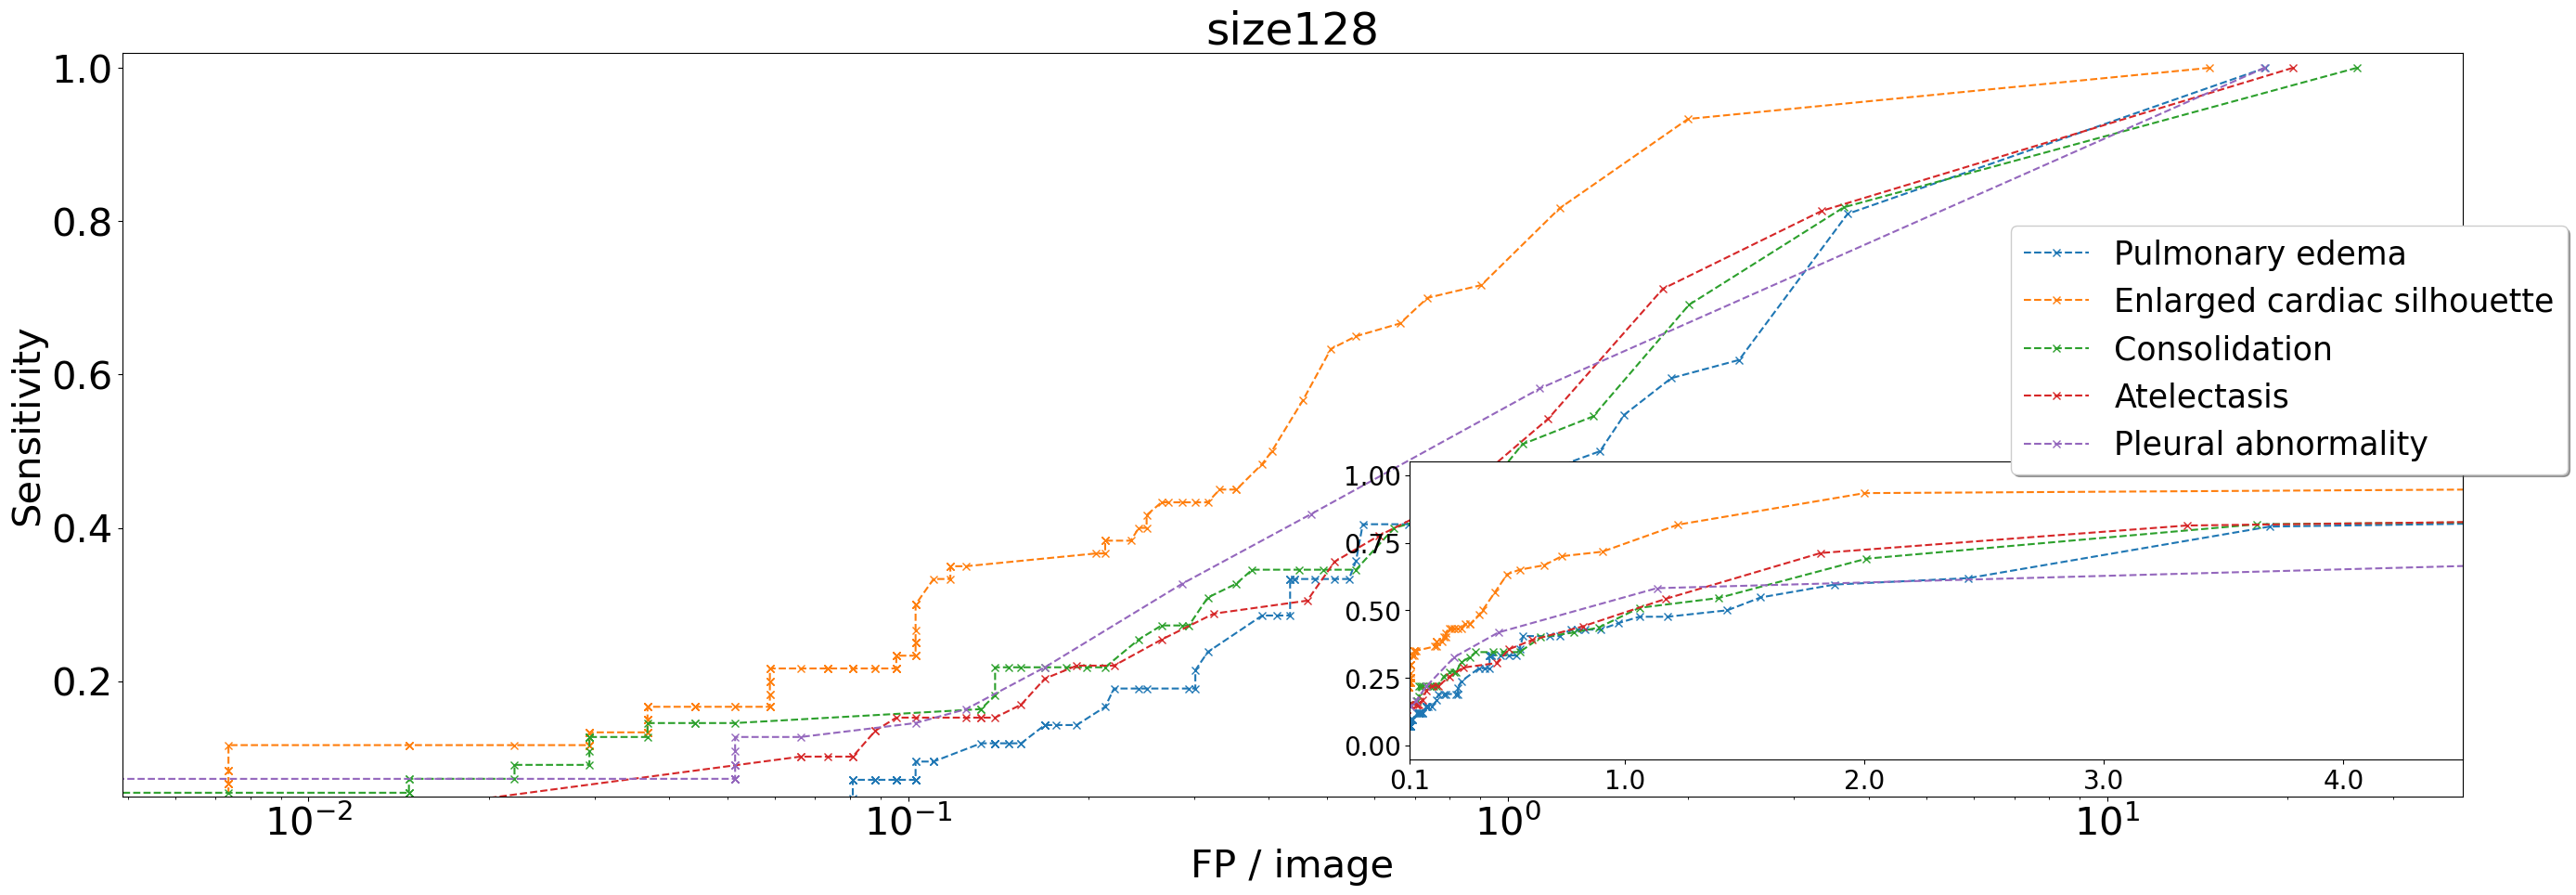

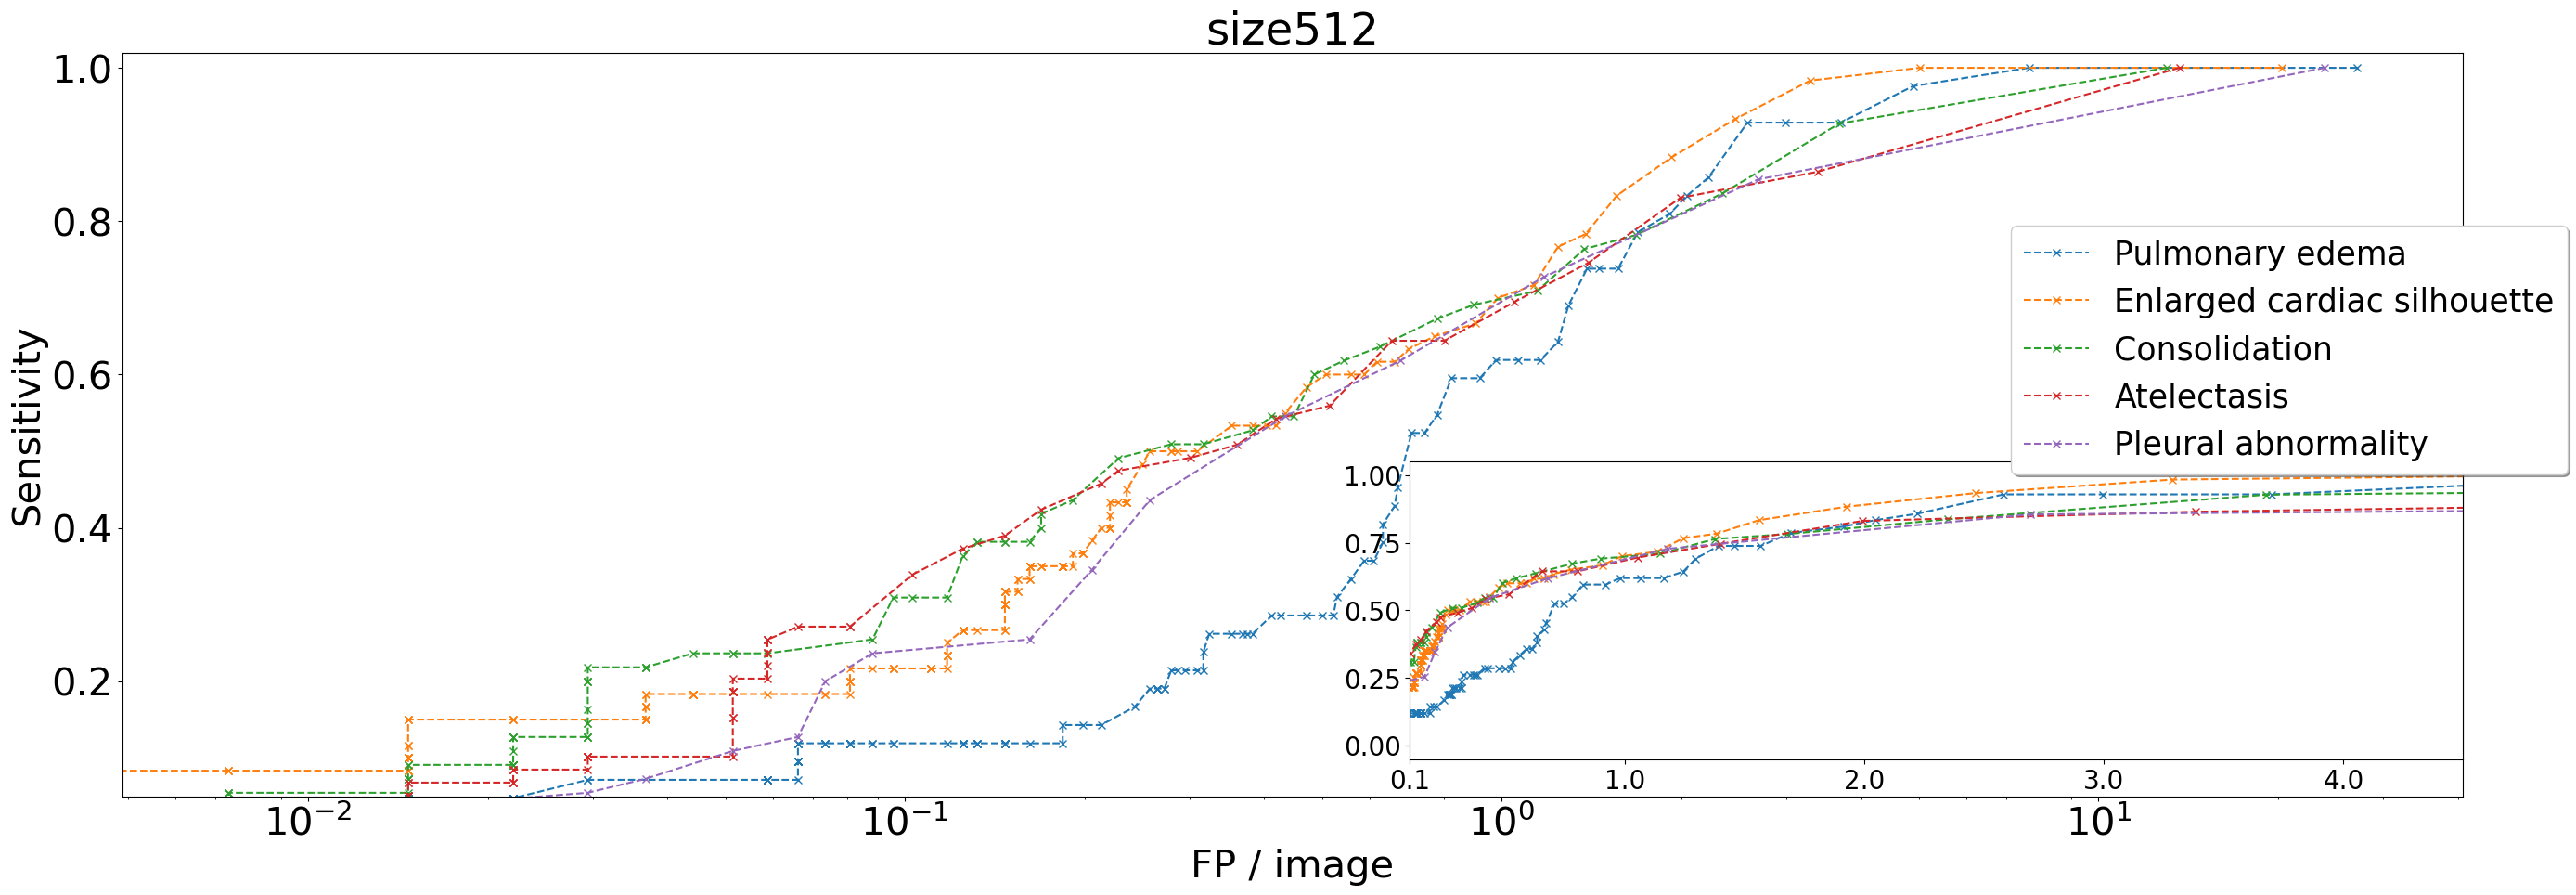

In [5]:
# just generate for the test set.
for select_model in tqdm(ImageSizeTest):
    clear_output()
    for score_thrs in score_thresholds:
        device = clean_memory_get_device()
        reproducibility()

        model, train_info, _, _ = get_trained_model(
            select_model,
            device,
        )
        model = model.to(device)
        model.eval()

        setup = train_info.model_setup
        iou_types = get_iou_types(model, setup)

        dataset_params_dict = {
            "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
            "labels_cols": setup.lesion_label_cols,
            "with_xrays_input": SourceStrs.XRAYS in setup.sources,
            "with_clincal_input": SourceStrs.CLINICAL in setup.sources,
            "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
            "fixations_mode_input": setup.fiaxtions_mode_input,
            "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
            "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
            "fixations_mode_label": setup.fiaxtions_mode_label,
            "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
            "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
            "clinical_numerical_cols": setup.clinical_num,
            "clinical_categorical_cols": setup.clinical_cat,
            "image_size": setup.image_size,
            "image_mean": setup.image_mean,
            "image_std": setup.image_std,
            "with_clinical_label": setup.with_clinical_label,
            "normalise_clinical_num": setup.normalise_clinical_num,
            "bbox_to_mask": setup.lesion_detection_use_mask,
            "use_clinical_df": setup.use_clinical_df,
        }

        detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
            dataset_params_dict=dataset_params_dict,
        )

        train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
            train_dataset,
            val_dataset,
            test_dataset,
            batch_size=setup.batch_size,
        )

        train_coco = None
        train_coco, val_coco, test_coco, _ = get_coco_eval_params(
            source_name=SourceStrs.XRAYS,
            task_name=TaskStrs.LESION_DETECTION,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            detect_eval_dataset=detect_eval_dataset,
            # iou_thrs=np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]),
            iou_thrs=np.array([0.5]),
            use_iobb=True,
            maxDets=[1, 5, 10, 30],
        )

        normal_range_eval_params_dict = get_eval_params_dict(
            detect_eval_dataset,
            iou_thrs=normal_iou_thrs,
        )

        model.task_performers["lesion-detection"].roi_heads.score_thresh = 0
        test_evaluator, _ = evaluate(
            setup=setup,
            model=model,
            data_loader=test_dataloader,
            device=device,
            params_dict=normal_range_eval_params_dict,
            coco=test_coco,
            iou_types=iou_types,
            return_dt_gt=True,
        )
        model.task_performers["lesion-detection"].roi_heads.score_thresh = 0.05

        stats, lls_accuracy, nlls_per_image = get_froc_curve(
            dataset=test_dataset,
            dts=test_evaluator["lesion-detection"].all_dts,
            all_gts=test_evaluator["lesion-detection"].all_gts,
            plot_title=naming_map[select_model],
            use_iou=True,
            n_sample_points=200,
            froc_save_folder="./froc_figures",
        )

        all_cat_ids = [None] + [
            detect_eval_dataset.disease_to_idx(d)
            for d in detect_eval_dataset.labels_cols
        ]

        for cat_id in all_cat_ids:
            cat_ids = (
                [
                    detect_eval_dataset.disease_to_idx(d)
                    for d in detect_eval_dataset.labels_cols
                ]
                if cat_id is None
                else [cat_id]
            )

            if not (cat_ids is None):
                normal_range_eval_params_dict["bbox"].catIds = cat_ids

            test_evaluator, _ = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=normal_range_eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
            )

            if cat_id is None:
                disease_str = "all"
            else:
                disease_str = detect_eval_dataset.label_idx_to_disease(cat_id)

            froc_v = get_interpolate_froc(
                stats=stats,
                lls_accuracy=lls_accuracy,
                nlls_per_image=nlls_per_image,
                cat_id=cat_id,
                fps_per_img=[0.5, 1, 2, 4],
                weight=True,
            )

            x_axis_values = np.logspace(-3, 2, 200).tolist()

            model_froc_curve = get_interpolate_froc(
                stats=stats,
                lls_accuracy=lls_accuracy,
                nlls_per_image=nlls_per_image,
                cat_id=cat_id,
                fps_per_img=x_axis_values,
                weight=True,
            )

            # raise StopIteration()

            df = pd.DataFrame(
                [
                    {
                        "num_fps": test_evaluator["lesion-detection"]
                        .coco_eval["bbox"]
                        .eval["num_fps"],  # @all_range, maxDet= p.maxDets[-1]
                        "num_fns": test_evaluator["lesion-detection"]
                        .coco_eval["bbox"]
                        .eval["num_fns"],
                        "num_tps": test_evaluator["lesion-detection"]
                        .coco_eval["bbox"]
                        .eval["num_tps"],
                        "coco_states": json.dumps(
                            test_evaluator["lesion-detection"].coco_eval["bbox"].stats
                        ),
                        "Sensitivity@ [avgFP=0.5]": froc_v[0],
                        "Sensitivity@ [avgFP=1]": froc_v[1],
                        "Sensitivity@ [avgFP=2]": froc_v[2],
                        "Sensitivity@ [avgFP=4]": froc_v[3],
                        "mFROC@[0.5,1,2,4]": froc_v.mean(),
                        "froc_curve": json.dumps(model_froc_curve.tolist()),
                        "x-axis": json.dumps(x_axis_values),
                    },
                ]
            )

            df.to_csv(
                Path(
                    os.path.join(
                        "./eval_results",
                        f"{select_model.value}_{disease_str}_{score_thrs}.csv",
                    )
                )
            )

            print_title(f"{select_model.value}-{disease_str}")
            print(df)


In [6]:
# from coco_froc_analysis.froc.froc_curve import froc_point, calc_scores
# all_stats = []
# stats = froc_point(TempRecord.gt, TempRecord.pr, 0.05, TempRecord.use_iou, TempRecord.iou_thres)